# Tutorial

## Tutorial

### Setting up environment

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import nsforest as ns
from nsforest import utils
from nsforest import preprocessing as pp
from nsforest import nsforesting
from nsforest import evaluating as ev
from nsforest import plotting as pl

### Data Exploration

#### Loading h5ad AnnData file

In [2]:
data_folder = "./data-for-test/"
file = data_folder + "adata_layer1.h5ad"
adata = sc.read_h5ad(file)
adata

AnnData object with n_obs × n_vars = 871 × 16497
    obs: 'cluster'

#### Defining `cluster_header` as cell type annotation. 

**Note:** Some datasets have multiple annotations per sample (ex. "broad_cell_type" and "granular_cell_type"). NS-Forest can be run on multiple `cluster_header`'s. Combining the parent and child markers may improve classification results. 

In [3]:
cluster_header = "cluster"

#### Defining `output_folder` for saving results

In [4]:
output_folder = "./results-from-tutorial/"

#### Looking at sample labels

In [ ]:
adata.obs_names

#### Looking at genes

**Note:** `adata.var_names` must be unique. If there is a problem, usually it can be solved by assigning `adata.var.index = adata.var["ensembl_id"]`. 

In [ ]:
adata.var_names

#### Checking cell annotation sizes 

**Note:** Some datasets are too large and need to be downsampled to be run through the pipeline. When downsampling, be sure to have all the granular cluster annotations represented. 

In [ ]:
adata.obs[cluster_header].value_counts()

### Preprocessing

#### Generating scanpy dendrogram

**Note:** Only run if there is no pre-defined dendrogram order. This step can still be run with no effects, but the runtime may increase. 

Dendrogram order is stored in `adata.uns["dendrogram_cluster"]["categories_ordered"]`. 

This dataset has a pre-defined dendrogram order, so running this step is not necessary. 

/Users/raymondleclair/Projects/NIH-NLM/Cell-KN/springbok-cell-kn-demos/.venv/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 16497 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


AnnData object with n_obs × n_vars = 871 × 16497
    obs: 'cluster'
    uns: 'pca', 'dendrogram_cluster'
    obsm: 'X_pca'
    varm: 'PCs'

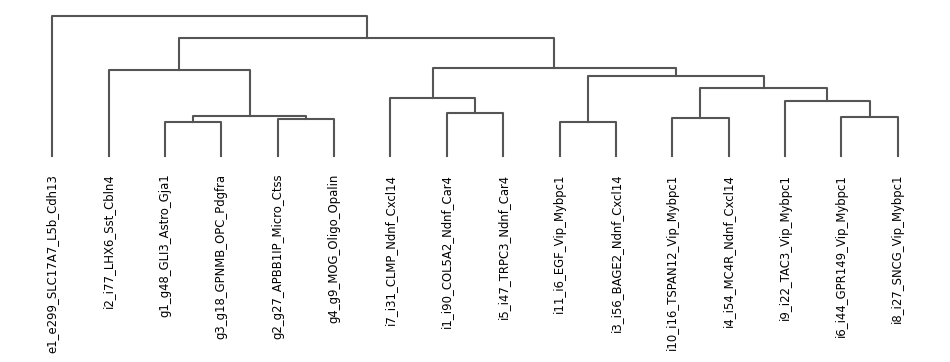

In [5]:
ns.pp.dendrogram(adata, cluster_header, save = False, show = False, output_folder = output_folder, outputfilename_suffix = cluster_header)

#### Calculating cluster medians per gene

Run `ns.pp.prep_medians` before running NS-Forest.

**Note:** Do **not** run if evaluating marker lists. Do **not** run when generating scanpy plots (e.g. dot plot, violin plot, matrix plot). 

In [6]:
adata = ns.pp.prep_medians(adata, cluster_header)
adata

Calculating medians...


Calculating medians (means) per cluster: 100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.53it/s]

Saving calculated medians as adata.varm.medians_cluster
--- 0.3828239440917969 seconds ---
median: 0.0
mean: 1.62611
std: 2.4904928
Only positive genes selected. 11688 positive genes out of 16497 total genes


AnnData object with n_obs × n_vars = 871 × 11688
    obs: 'cluster'
    uns: 'pca', 'dendrogram_cluster'
    obsm: 'X_pca'
    varm: 'PCs', 'medians_cluster'

#### Calculating binary scores per gene per cluster

Run `ns.pp.prep_binary_scores` before running NS-Forest. Do not need to run if evaluating marker lists. Do not need to run when generating scanpy plots. 

In [7]:
adata = ns.pp.prep_binary_scores(adata, cluster_header)
adata

Calculating binary scores...


Calculating binary scores per cluster: 100%|████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]

Saving calculated binary scores as adata.varm.binary_scores_cluster
--- 12.400921106338501 seconds ---
median: 0.1
mean: 0.2016436226562706
std: 0.25240082537926


AnnData object with n_obs × n_vars = 871 × 11688
    obs: 'cluster'
    uns: 'pca', 'dendrogram_cluster'
    obsm: 'X_pca'
    varm: 'PCs', 'medians_cluster', 'binary_scores_cluster'

#### Plotting median and binary score distributions

In [ ]:
plt.clf()
filename = output_folder + cluster_header + '_medians.png'
print(f"Saving median distributions as...\n{filename}")
a = plt.figure(figsize = (6, 4))
a = plt.hist(adata.varm["medians_" + cluster_header].unstack(), bins = 100)
a = plt.title(f'{file.split("/")[-1].replace(".h5ad", "")}: {"medians_" + cluster_header} histogram')
a = plt.xlabel("medians_" + cluster_header)
a = plt.yscale("log")
a = plt.savefig(filename, bbox_inches='tight')
plt.show()

In [ ]:
plt.clf()
filename = output_folder + cluster_header + '_binary_scores.png'
print(f"Saving binary_score distributions as...\n{filename}")
a = plt.figure(figsize = (6, 4))
a = plt.hist(adata.varm["binary_scores_" + cluster_header].unstack(), bins = 100)
a = plt.title(f'{file.split("/")[-1].replace(".h5ad", "")}: {"binary_scores_" + cluster_header} histogram')
a = plt.xlabel("binary_scores_" + cluster_header)
a = plt.yscale("log")
a = plt.savefig(filename, bbox_inches='tight')
plt.show()

#### Saving preprocessed AnnData as new h5ad

In [ ]:
filename = file.replace(".h5ad", "_preprocessed.h5ad")
print(f"Saving new anndata object as...\n{filename}")
adata.write_h5ad(filename)

### Running NS-Forest

**Note:** Do not run NS-Forest if only evaluating input marker lists. 

In [8]:
outputfilename_prefix = cluster_header
results = nsforesting.NSForest(adata, cluster_header, save_supplementary = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

Preparing adata...
--- 0.00279998779296875 seconds ---
Pre-selecting genes based on binary scores...
	BinaryFirst_high Threshold (mean + 2 * std): 0.7064452734147906
	Average number of genes after gene_selection in each cluster: 735.5
Saving number of genes selected per cluster as...
./results-from-tutorial/cluster_gene_selection.csv
Number of clusters to evaluate: 16
1 out of 16:
	e1_e299_SLC17A7_L5b_Cdh13
	Pre-selected 1356 genes to feed into Random Forest.
	['LINC00507']
	fbeta: 0.9597411933860532
	PPV: 0.978021978021978
	recall: 0.8929765886287625
2 out of 16:
	g1_g48_GLI3_Astro_Gja1
	Pre-selected 583 genes to feed into Random Forest.
	['LINC00498']
	fbeta: 0.95
	PPV: 1.0
	recall: 0.7916666666666666
3 out of 16:
	g2_g27_APBB1IP_Micro_Ctss
	Pre-selected 420 genes to feed into Random Forest.
	['ADAM28', 'PTPRC']
	fbeta: 0.975609756097561
	PPV: 1.0
	recall: 0.8888888888888888
4 out of 16:
	g3_g18_GPNMB_OPC_Pdgfra
	Pre-selected 353 genes to feed into Random Forest.
	['GPNMB', 'OLIG2']


Calculating medians (means) per cluster: 100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 2142.14it/s]

Saving final results table as...
./results-from-tutorial/cluster_results.csv
--- 14.628545045852661 seconds ---


In [ ]:
results

#### Plotting classification metrics from NS-Forest results

In [ ]:
ns.pl.boxplot(results, "f_score", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.boxplot(results, "PPV", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.boxplot(results, "recall", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.boxplot(results, "onTarget", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.scatter_w_clusterSize(results, "f_score", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.scatter_w_clusterSize(results, "PPV", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.scatter_w_clusterSize(results, "recall", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.scatter_w_clusterSize(results, "onTarget", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

### Plotting scanpy dot plot, violin plot, matrix plot for NS-Forest markers

**Note:** Assign pre-defined dendrogram order here **or** use `adata.uns["dendrogram_" + cluster_header]["categories_ordered"]`. 

In [ ]:
to_plot = results.copy()

In [ ]:
dendrogram = [] # custom dendrogram order
dendrogram = list(adata.uns["dendrogram_" + cluster_header]["categories_ordered"])
to_plot["clusterName"] = to_plot["clusterName"].astype("category")
to_plot["clusterName"] = to_plot["clusterName"].cat.set_categories(dendrogram)
to_plot = to_plot.sort_values("clusterName")
to_plot = to_plot.rename(columns = {"NSForest_markers": "markers"})
to_plot.head()

In [ ]:
markers_dict = dict(zip(to_plot["clusterName"], to_plot["markers"]))
markers_dict

In [ ]:
ns.pl.dotplot(adata, markers_dict, cluster_header, dendrogram = dendrogram, save = True, output_folder = output_folder, outputfilename_suffix = outputfilename_prefix)

In [ ]:
ns.pl.stackedviolin(adata, markers_dict, cluster_header, dendrogram = dendrogram, save = True, output_folder = output_folder, outputfilename_suffix = outputfilename_prefix)

In [ ]:
ns.pl.matrixplot(adata, markers_dict, cluster_header, dendrogram = dendrogram, save = True, output_folder = output_folder, outputfilename_suffix = outputfilename_prefix)

### Evaluating input marker list

#### Getting marker list in dictionary format: {cluster: marker_list}

In [ ]:
markers = pd.read_csv("../demo_data/marker_list.csv")
markers_dict = utils.prepare_markers(markers, "clusterName", "markers")
markers_dict

In [ ]:
outputfilename_prefix = "marker_eval"
evaluation_results = ev.DecisionTree(adata, cluster_header, markers_dict, combinations = False, use_mean = False, 
                                     save_supplementary = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
evaluation_results

#### Plotting classification metrics from marker evaluation

In [ ]:
ns.pl.boxplot(evaluation_results, "f_score", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.boxplot(evaluation_results, "PPV", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.boxplot(evaluation_results, "recall", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.boxplot(evaluation_results, "onTarget", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.scatter_w_clusterSize(evaluation_results, "f_score", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.scatter_w_clusterSize(evaluation_results, "PPV", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.scatter_w_clusterSize(evaluation_results, "recall", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.scatter_w_clusterSize(evaluation_results, "onTarget", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

### Plotting scanpy dot plot, violin plot, matrix plot for input marker list

**Note:** Assign pre-defined dendrogram order here **or** use `adata.uns["dendrogram_" + cluster_header]["categories_ordered"]`. 

In [ ]:
to_plot = evaluation_results.copy()

In [ ]:
dendrogram = [] # custom dendrogram order
dendrogram = list(adata.uns["dendrogram_" + cluster_header]["categories_ordered"])
to_plot["clusterName"] = to_plot["clusterName"].astype("category")
to_plot["clusterName"] = to_plot["clusterName"].cat.set_categories(dendrogram)
to_plot = to_plot.sort_values("clusterName").reset_index(drop = True)
to_plot = to_plot.rename(columns = {"NSForest_markers": "markers"})
to_plot.head()

In [ ]:
markers_dict = dict(zip(to_plot["clusterName"], to_plot["markers"]))
markers_dict

In [ ]:
ns.pl.dotplot(adata, markers_dict, cluster_header, dendrogram = dendrogram, save = True, output_folder = output_folder, outputfilename_suffix = outputfilename_prefix)

In [ ]:
ns.pl.stackedviolin(adata, markers_dict, cluster_header, dendrogram = dendrogram, save = True, output_folder = output_folder, outputfilename_suffix = outputfilename_prefix)

In [ ]:
ns.pl.matrixplot(adata, markers_dict, cluster_header, dendrogram = dendrogram, save = True, output_folder = output_folder, outputfilename_suffix = outputfilename_prefix)